# Modifications

Link to Interactive Notebook: 
https://colab.research.google.com/drive/1sbJTsgCsAQwCkGdLXK7EdgkaTpiTGBM1#scrollTo=T71qxHyh9p23

1. Reduced Input Dimension
2. Different handling of xco2: merge the value in as an additional input in the fully connected layer (?)

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-10-19 15:45:13.804172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"


chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
def convert_nan(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    #print(min_val)
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel)+new_min 
    return arr
  

def preprocess_image_reduced(data,xco2=False):
  """
  dimension reduced the output should be  (180,360,5)
  """
  if xco2:
    return data
  return scale_image(convert_nan(data))

In [4]:
#xco2 values are a constant value across the globe, so creating an image layer with constant value for the model
xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)


chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)


340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


In [5]:
X=X.reshape((421,180,360,5))
X.shape

(421, 180, 360, 5)

In [6]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

In [19]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K


def custom_rmse(y_true, y_pred):
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    #y_true = y_true[y_true != 0]
    #y_pred = y_pred[y_true != 0]
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))



In [12]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu', padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 120, 64)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 180, 360, 128)    

In [13]:
base_model.compile(loss=custom_rmse, optimizer="nadam", metrics=["mean_squared_error"])

In [14]:
model_path="../models/base_model/base_model_new.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)



Epoch 1/100
14/14 [==============================] - 21s 627ms/step - loss: 98.7519 - mean_squared_error: 21476.7732 - val_loss: 44.9499 - val_mean_squared_error: 2128.6951
Epoch 2/100
14/14 [==============================] - 6s 428ms/step - loss: 42.2821 - mean_squared_error: 1905.7858 - val_loss: 36.8775 - val_mean_squared_error: 1554.0530
Epoch 3/100
14/14 [==============================] - 6s 428ms/step - loss: 37.8200 - mean_squared_error: 1641.4204 - val_loss: 33.4322 - val_mean_squared_error: 1314.6666
Epoch 4/100
14/14 [==============================] - 6s 429ms/step - loss: 33.2744 - mean_squared_error: 1302.7093 - val_loss: 35.7304 - val_mean_squared_error: 1504.9075
Epoch 5/100
14/14 [==============================] - 6s 428ms/step - loss: 33.3128 - mean_squared_error: 1301.0972 - val_loss: 38.7815 - val_mean_squared_error: 1751.0498
Epoch 6/100
14/14 [==============================] - 6s 428ms/step - loss: 33.2220 - mean_squared_error: 1296.9308 - val_loss: 28.7688 - val_me

In [23]:

best_model = tf.keras.models.load_model('../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 1s 580ms/step


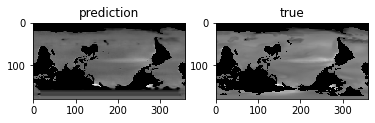

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

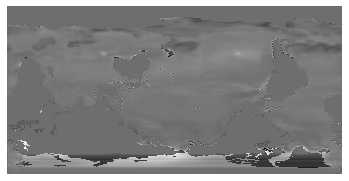

In [25]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

In [51]:

#kernel_size matters, 2 does not work

model1 = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model1.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 120, 64)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 60, 120, 128)      409728    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 40, 128)      

In [52]:
model1.compile(loss=custom_rmse, optimizer="nadam", metrics=["mean_squared_error"])

In [53]:
model_path="../models/base_model/reduceddim_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model1.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)




Epoch 1/100
14/14 [==============================] - 11s 610ms/step - loss: 3049.5762 - mean_squared_error: 78201038.2942 - val_loss: 42.1013 - val_mean_squared_error: 1845.5126
Epoch 2/100
14/14 [==============================] - 7s 516ms/step - loss: 43.9490 - mean_squared_error: 2118.4897 - val_loss: 36.7850 - val_mean_squared_error: 1549.5947
Epoch 3/100
14/14 [==============================] - 7s 516ms/step - loss: 37.4358 - mean_squared_error: 1627.2228 - val_loss: 37.7126 - val_mean_squared_error: 1675.9331
Epoch 4/100
14/14 [==============================] - 7s 517ms/step - loss: 35.9581 - mean_squared_error: 1502.5178 - val_loss: 34.3864 - val_mean_squared_error: 1384.4196
Epoch 5/100
14/14 [==============================] - 7s 516ms/step - loss: 33.6318 - mean_squared_error: 1325.8400 - val_loss: 32.4356 - val_mean_squared_error: 1245.9977
Epoch 6/100
14/14 [==============================] - 7s 517ms/step - loss: 32.6140 - mean_squared_error: 1254.6266 - val_loss: 31.5453 - v

In [54]:

best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 413ms/step


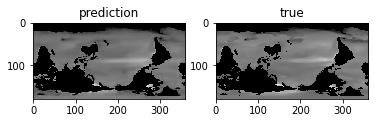

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('model1_prediction.png')